# Loading Crop Data

In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
# Read in data from local file
seeds_df = pd.read_csv('./psd_oilseeds.csv', engine='python')
seeds_df.head()

,Commodity_Code,Commodity_Description,Country_Code,Country_Name,Market_Year,Calendar_Year,Month,Attribute_ID,Attribute_Description,Unit_ID,Unit_Description,Value
0,813700,"Meal, Copra",AS,Australia,1964,2006,6,20,Beginning Stocks,8,(1000 MT),0.0
1,813700,"Meal, Copra",AS,Australia,1964,2006,6,7,Crush,8,(1000 MT),33.0
2,813700,"Meal, Copra",AS,Australia,1964,2006,6,125,Domestic Consumption,8,(1000 MT),11.0
3,813700,"Meal, Copra",AS,Australia,1964,2006,6,176,Ending Stocks,8,(1000 MT),0.0
4,813700,"Meal, Copra",AS,Australia,1964,2006,6,88,Exports,8,(1000 MT),0.0


In [3]:
ukraine_data = seeds_df[(seeds_df['Country_Name'] == 'Ukraine') & (seeds_df['Commodity_Description'] == 'Oilseed, Sunflowerseed')] # Limit to sunflowers in Ukraine
ukraine_data = ukraine_data.drop(columns=['Commodity_Code', 'Commodity_Description', 'Country_Code', 'Country_Name']) # Drop columns that only have 1 value
ukraine_data = ukraine_data.drop(columns=['Attribute_ID', 'Unit_ID', 'Calendar_Year', 'Month']) # Drop not used values

In [4]:
delete_index = ukraine_data[~ukraine_data['Attribute_Description'].isin(['Production', 'Yield', 'Area Harvested'])].index # Only take points that correspond to utilized values
ukraine_data.drop(delete_index, inplace=True)

ukraine_data = ukraine_data.rename(columns={'Market_Year': 'year'}) # Rename columns to allow for joining with GPM dataset
ukraine_data = ukraine_data.rename(columns={'Value': 'value'})

ukraine_data.head()

,year,Attribute_Description,Unit_Description,value
744624,1987,Area Harvested,(1000 HA),1535.00
744633,1987,Production,(1000 MT),2716.00
744636,1987,Yield,(MT/HA),1.77
744637,1988,Area Harvested,(1000 HA),1567.00
744646,1988,Production,(1000 MT),2775.00


In [5]:
# Split dataset into separate datasets for production, yield, and area harvested
crop_production = ukraine_data[ukraine_data['Attribute_Description'] == 'Production']
crop_production = crop_production.drop(columns=['Attribute_Description'])

crop_yield = ukraine_data[ukraine_data['Attribute_Description'] == 'Yield']
crop_yield = crop_yield.drop(columns=['Attribute_Description'])

area_harvested = ukraine_data[ukraine_data['Attribute_Description'] == 'Area Harvested']
area_harvested = area_harvested.drop(columns=['Attribute_Description'])

# Plotting Crop Data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

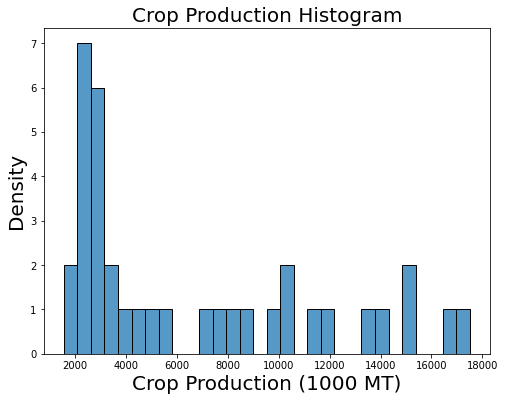

In [7]:
# Plot distribution of crop production values
X = crop_production.drop(columns=['value'])
y = crop_production['value']

plt.figure(figsize=(8,6))
s = sns.histplot(y, bins = 30)
s.set_xlabel("Crop Production {0}".format(crop_production['Unit_Description'].iat[0]), fontsize = 20)
s.set_ylabel("Density", fontsize = 20)
title = plt.title("Crop Production Histogram", fontsize = 20)

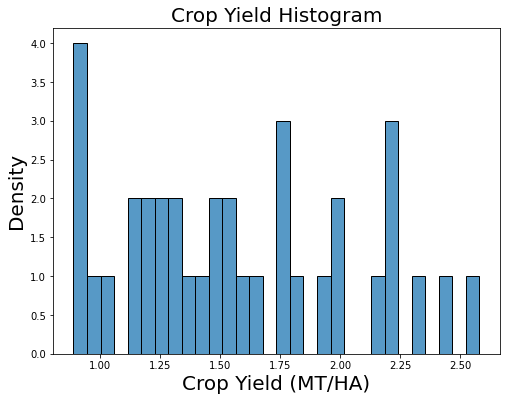

In [8]:
# Plot distribution of crop yield values
X = crop_yield.drop(columns=['value'])
y = crop_yield['value']

plt.figure(figsize=(8,6))
s = sns.histplot(y, bins = 30)
s.set_xlabel("Crop Yield {0}".format(crop_yield['Unit_Description'].iat[0]), fontsize = 20)
s.set_ylabel("Density", fontsize = 20)
title = plt.title("Crop Yield Histogram", fontsize = 20)

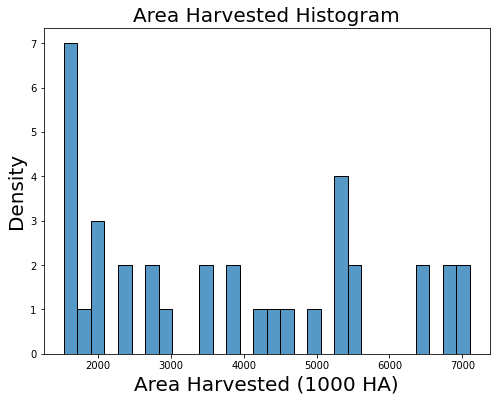

In [9]:
# Plot distribution of area harvested values
X = area_harvested.drop(columns=['value'])
y = area_harvested['value']

plt.figure(figsize=(8,6))
s = sns.histplot(y, bins = 30)
s.set_xlabel("Area Harvested {0}".format(area_harvested['Unit_Description'].iat[0]), fontsize = 20)
s.set_ylabel("Density", fontsize = 20)
title = plt.title("Area Harvested Histogram", fontsize = 20)

In [10]:
# Combine crop production and area harvested values to see if years match
extracted_cols1 = area_harvested[['year', 'value']]
extracted_cols2 = crop_yield[['year', 'value']]
extracted_cols1 = extracted_cols1.rename(columns={'value': 'Area_Harvested'})
extracted_cols2 = extracted_cols2.rename(columns={'value': 'Crop_Yield'})
complete_table = pd.merge(left=extracted_cols1, right=crop_production, on=['year'])
complete_table = pd.merge(left=extracted_cols2, right=complete_table, on=['year'])

# Normalize area harvested, crop production, and crop yield values for comparison
normalized_table = complete_table.copy()
normalized_table['value'] = (normalized_table['value'] - normalized_table['value'].min()) / (normalized_table['value'].max() - normalized_table['value'].min())
normalized_table['Area_Harvested'] = (normalized_table['Area_Harvested'] - normalized_table['Area_Harvested'].min()) / (normalized_table['Area_Harvested'].max() - normalized_table['Area_Harvested'].min())
normalized_table['Crop_Yield'] = (normalized_table['Crop_Yield'] - normalized_table['Crop_Yield'].min()) / (normalized_table['Crop_Yield'].max() - normalized_table['Crop_Yield'].min())

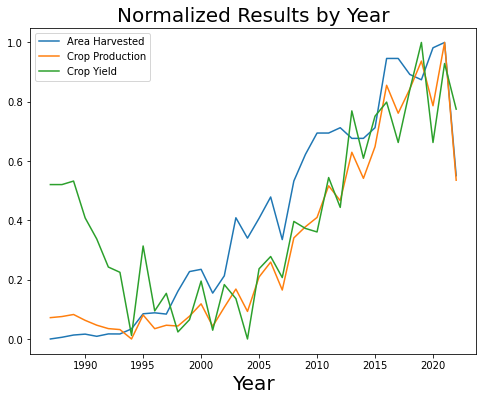

In [11]:
# Plot comparisons of relative area harvested, crop production, and crop yield values by year
plt.figure(figsize=(8,6))
plt.plot(normalized_table['year'], normalized_table['Area_Harvested'], label = "Area Harvested")
plt.plot(normalized_table['year'], normalized_table['value'], label = "Crop Production")
plt.plot(normalized_table['year'], normalized_table['Crop_Yield'], label = "Crop Yield")
plt.title('Normalized Results by Year', fontsize = 20)
plt.xlabel('Year', fontsize=20)
ax = plt.gca()
ax.set_facecolor("white")
plt.legend()
plt.show()

# Merge with GPM Data

In [12]:
gpm_df = pd.read_csv('GPM_DATA.csv', engine='python')
merged_df = pd.merge(left=gpm_df, right=complete_table, on=['year']) # Combine the GPM dataset and modified crop dataset
merged_df.head(10)

,year,04,05,06,07,08,09,Crop_Yield,Area_Harvested,Unit_Description,value
0,2010,30.694435,81.588577,58.637985,78.923126,17.362423,69.998413,1.50,5400.0,(1000 MT),8100.0
1,2011,45.750355,40.541813,116.750931,79.271660,32.360817,22.124327,1.81,5400.0,(1000 MT),9800.0
2,2012,47.437500,47.412399,45.361950,55.098766,83.910904,28.993668,1.64,5500.0,(1000 MT),9000.0
3,2013,20.637459,37.462730,63.991859,63.322220,37.813324,104.675720,2.19,5300.0,(1000 MT),11600.0
4,2014,58.613281,97.672356,83.434563,52.785389,34.234802,56.856579,1.92,5300.0,(1000 MT),10200.0
5,2015,89.006805,56.045376,77.334534,50.652809,13.692476,20.045979,2.16,5500.0,(1000 MT),11900.0
6,2016,63.119766,117.061249,68.671516,40.537788,54.796494,30.939898,2.24,6800.0,(1000 MT),15200.0
7,2017,74.414261,38.882072,36.977493,65.464905,25.178944,27.750265,2.01,6800.0,(1000 MT),13700.0
8,2018,20.901785,32.782516,61.801449,91.193832,5.031616,61.841522,2.31,6500.0,(1000 MT),15000.0
9,2019,55.347668,76.584427,44.642345,61.100101,39.235573,25.776859,2.58,6400.0,(1000 MT),16500.0


# Evaluating Feature Importances

In [13]:
# Break the dataset into independent and dependent variables

# Drop all values except crop production and monthly rainfall averages
X = merged_df.drop(columns=['year', 'Crop_Yield', 'Area_Harvested', 'Unit_Description', 'value'])
y = merged_df['value']

# Standardize the independent features
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

# Split the features into train and test groups, with 25% of the data being used for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=42)

from sklearn.metrics import mean_squared_error

Text(0.5, 1.0, 'Feature Importances for Predicting Crop Production for Seed(2)')

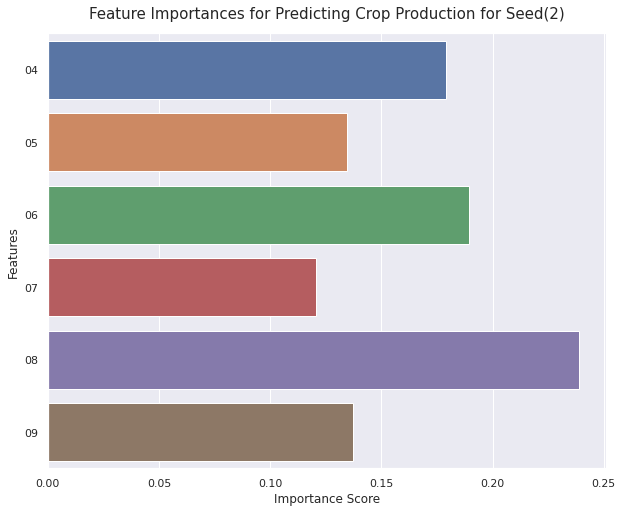

In [14]:
# Use a Random Forest Classifier to calculate feature importances
np.random.seed(1)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Plot out the importances of each attribute in regards to crop production prediction
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Feature Importances for Predicting Crop Production for Seed(2)", fontsize=15, pad=15)

# Linear Regression Model

In [15]:
np.random.seed(1)
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Train

lin_reg_y_pred = lin_reg.predict(X_test) # Predict

# Calculate root mean squared error
lin_rmse = math.sqrt(mean_squared_error(y_test, lin_reg_y_pred))
print(lin_rmse)

6651.81237312822


# Lasso Regression Model

In [16]:
np.random.seed(1)
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train) # Train

lasso_y_pred = lasso.predict(X_test) # Predict

# Calculate root mean squared error
lasso_rmse = math.sqrt(mean_squared_error(y_test, lasso_y_pred))
print(lasso_rmse)

6651.643747204339


# KNN Regression Model

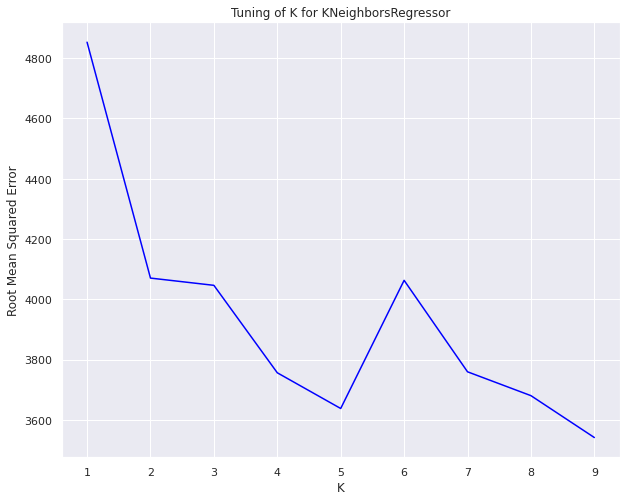

In [17]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsRegressor

knn_mse_errors = []
for i in range(1,10): # Build models for n_neighbors values from 1 to 9
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train, y_train) # Train

  knn_y_pred = knn.predict(X_test) # Predict
  knn_mse_errors.append(math.sqrt(mean_squared_error(y_test, knn_y_pred))) # Store RMSE value

# Plot the results of all iterations
plt.title("Tuning of K for KNeighborsRegressor")
plt.xlabel("K")
plt.ylabel("Root Mean Squared Error")
plt.plot(np.arange(1, 10), np.array(knn_mse_errors), color ="blue")
plt.show()

In [18]:
# Create a KNN regressor model with the best performing n_neighbors value from the graph
np.random.seed(1)
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

# Print the predictions of the model
print(knn_y_pred)

# Print the rmse of the model
print(math.sqrt(mean_squared_error(y_test, knn_y_pred)))

[12655.55555556 12655.55555556 12655.55555556]
3541.1513786365804


In [19]:
# Create a KNN regressor model with the second best performing n_neighbors value from the graph
# Looking to see if this model doesn't predict the same value every time
np.random.seed(1)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

# Print the predictions of the model
print(knn_y_pred)

# Print the rmse of the model
print(math.sqrt(mean_squared_error(y_test, knn_y_pred)))

[12160. 12000. 12060.]
3637.5449596305107


# Decision Tree Regression Model

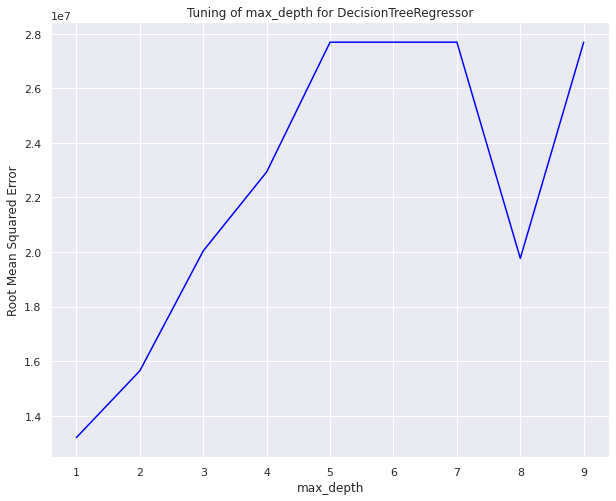

In [20]:
np.random.seed(1)
from sklearn.tree import DecisionTreeRegressor

dt_mse_errors = []
for i in range(1,10): # Build models for max_depth values from 1 to 9
  dt = DecisionTreeRegressor(max_depth=i)
  dt.fit(X_train, y_train) # Train

  dt_pred_y = dt.predict(X_test) # Predict
  dt_mse_errors.append(mean_squared_error(y_test, dt_pred_y)) # Store RMSE value

# Plot the results of all iterations
plt.title("Tuning of max_depth for DecisionTreeRegressor")
plt.xlabel("max_depth")
plt.ylabel("Root Mean Squared Error")
plt.plot(np.arange(1, 10), np.array(dt_mse_errors), color ="blue")
plt.show()

In [21]:
# Create a Decision Tree regressor model with the best performing max_depth value from the graph
np.random.seed(1)
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)

# Print the predictions of the model
print(dt_y_pred)

# Print the rmse of the model
print(math.sqrt(mean_squared_error(y_test, dt_y_pred)))

[12050. 12050. 12050.]
3633.5244598048325


In [22]:
# Create a Decision Tree regressor model with another max_depth to see if it doesn't predict the same value every time
np.random.seed(1)
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)

# Print the predictions of the model
print(dt_y_pred)

# Print the rmse of the model
print(math.sqrt(mean_squared_error(y_test, dt_y_pred)))

[11120. 11120. 11120.]
3955.8058597459003


# Random Forest Regression Model

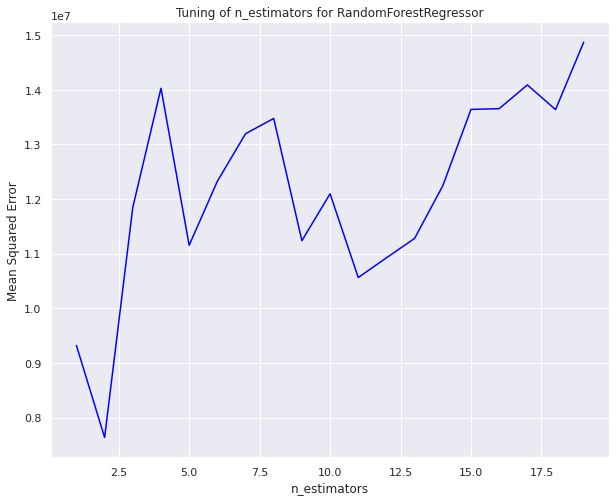

In [23]:
np.random.seed(1)
from sklearn.ensemble import RandomForestRegressor

rf_mse_errors = []
for i in range(1,20): # Build models for n_estimators values from 1 to 19
  rf = RandomForestRegressor(max_depth=2, n_estimators=i, random_state=42)
  rf.fit(X_train, y_train) # Train

  rf_y_pred = rf.predict(X_test) # Predict
  rf_mse_errors.append(mean_squared_error(y_test, rf_y_pred)) # Store RMSE value

# Plot the results of all iterations
plt.title("Tuning of n_estimators for RandomForestRegressor")
plt.xlabel("n_estimators")
plt.ylabel("Mean Squared Error")
plt.plot(np.arange(1, 20), np.array(rf_mse_errors), color ="blue")
plt.show()

In [24]:
# Create a Random Forest regressor model with the best performing n_estimators value from the graph
np.random.seed(1)
rf = RandomForestRegressor(max_depth=2, n_estimators=2, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Print the predictions of the model
print(rf_y_pred)

# Print the rmse of the model
print(mean_squared_error(y_test, rf_y_pred))
print(rf.score(X_test,y_test))

[12183.33333333 14900.         12183.33333333]
7635740.740740739
0.3881617996201331
